<a href="https://colab.research.google.com/github/yeahxne/Deep_Learning_2022/blob/main/Colab_Py37.%5B%EC%8B%A4%EC%8A%B505%5D%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D(2)-transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)

Saving utils.py to utils.py


38073

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/aircraft.zip

Archive:  /content/drive/MyDrive/aircraft.zip
   creating: aircraft/test/
   creating: aircraft/test/airplane/
  inflating: aircraft/test/airplane/a_test01.jpeg  
  inflating: aircraft/test/airplane/a_test02.jpeg  
  inflating: aircraft/test/airplane/a_test03.jpeg  
  inflating: aircraft/test/airplane/a_test04.jpeg  
  inflating: aircraft/test/airplane/a_test05.jpeg  
  inflating: aircraft/test/airplane/a_test06.jpeg  
  inflating: aircraft/test/airplane/a_test07.jpeg  
  inflating: aircraft/test/airplane/a_test08.jpeg  
  inflating: aircraft/test/airplane/a_test09.jpeg  
  inflating: aircraft/test/airplane/a_test10.jpeg  
   creating: aircraft/test/helicopter/
  inflating: aircraft/test/helicopter/h_test01.jpeg  
  inflating: aircraft/test/helicopter/h_test02.jpeg  
  inflating: aircraft/test/helicopter/h_test03.jpeg  
  inflating: aircraft/test/helicopter/h_test04.jpeg  
  inflating: aircraft/test/helicopter/h_test05.jpeg  
  inflating: aircraft/test/helicopter/h_test06.jpeg  
  infl

## 1. Settings
### 1) Important required libraries

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [5]:
batch_size = 16 #64  #1
learning_rate = 0.0001
epoch = 20
 
n_node = 1024 # customized last layer의 노드 수. 64, 128, 256, 512, 1025
dropratio = 0.5 # 얼마나 drop시킬지 inverse keepratio

imgsize = 256

## 2. Data Loader
### 트레이닝 데이터

In [6]:
img_dir = "aircraft/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2),  # CenterCrop(512)
            transforms.RandomCrop(imgsize),    # RandomCrop
            transforms.RandomHorizontalFlip(), # RandomHorizontalFlip
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
        ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

82


### 고정된 데이터 셋

In [7]:
# 2. Dev data
img_dir = "aircraft/valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

In [8]:
# 3. Test data
img_dir = "aircraft/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

test_batch = data.DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, num_workers=2)

In [9]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" %labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 2
['airplane', 'helicopter']
{'airplane': 0, 'helicopter': 1}
82
Training: 82, Dev: 9, Test: 20


In [10]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['airplane', 'helicopter']
['airplane', 'helicopter']
['airplane', 'helicopter']


## 3. Model
### 1) Pretrained VGG Model

In [11]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#     print("ysb[%d]" %cnt)
#     print(i)
#     cnt = cnt+1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [12]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [13]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])

        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, nclass),
        )
        # weigth initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # ReLU 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        # layer0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [14]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [15]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [16]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [26]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    netname = '/airplanehelicopter_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"%(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/airplanehelicopter_vgg19_10'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#    # 학습을 재시작한다면
#    netname = '../almondpeanut_vgg19.pkl'
#    model = torch.load(netname)
#    # 파라미터 학습 여부 결정
#    for params in model.layer0.parameters():
#        params.required_grad = False

#    for params in model.layer1.parameters():
#        params.required_grad = True
#    for i in range(34, epoch):
   
    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step ==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl' %i, )
            print("\[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
        
            # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌.
            model.eval() 
        
            # train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec..." %(total_time))
        
            # graph 그리기 
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Correct of train: 87.80, dev: 100.00, test: 90.00
0..
\[0/20] loss: 0.691, 
Correct of train: 82.93, dev: 100.00, test: 85.00, 
time: 2.03 sec...
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..
\[10/20] loss: 0.423, 
Correct of train: 85.37, dev: 88.89, test: 75.00, 
time: 22.42 sec...
11..
12..
13..
14..
15..
16..
17..
18..
19..
\[19/20] loss: 0.773, 
Correct of train: 87.80, dev: 88.89, test: 85.00, 
time: 40.94 sec...
Total time: 40.94 sec


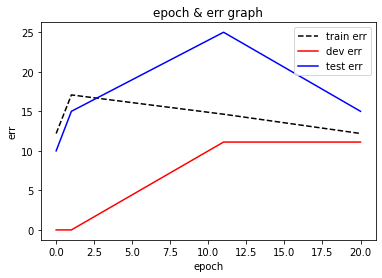

In [27]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc = "upper right")
    plt.show()

## 6. Evaluation for dev & test data

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


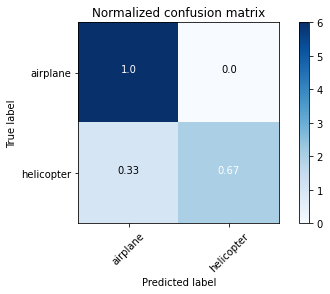

Confusion matrix, without normalization


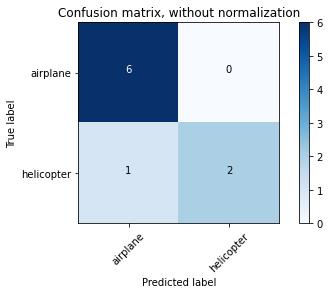

	 acc  |	 pre  |	 rec  |	 f1
 airplane: 0.89 |	 0.86 |	 1.00 |	 0.92
 helicopter: 0.89 |	 1.00 |	 0.67 |	 0.80
*accuracy: 0.89, precision: 0.93, recall: 0.83, *f1 score: 0.86
[AP]
airplane: 1.00
helicopter: 1.00

[mAP] 1.000
[miAP] 0.944


(array([0, 0, 0, 0, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1]),
 array([0.6428017 , 0.59938496, 0.69222981, 0.6257292 , 0.69114172,
        0.85575908, 0.70558375, 0.78801215, 0.51171952]))

In [28]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


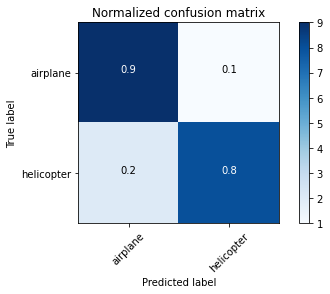

Confusion matrix, without normalization


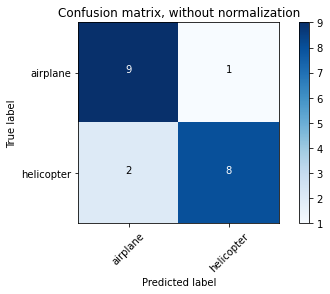

	 acc  |	 pre  |	 rec  |	 f1
 airplane: 0.85 |	 0.82 |	 0.90 |	 0.86
 helicopter: 0.85 |	 0.89 |	 0.80 |	 0.84
*accuracy: 0.85, precision: 0.85, recall: 0.85, *f1 score: 0.85
[AP]
airplane: 0.97
helicopter: 0.97

[mAP] 0.973
[miAP] 0.925


In [29]:
model.eval()
_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: airplane
 True predicted images/total airplane category: 6 / 6
Predicted probability:
[0.6428017 0.3571983]


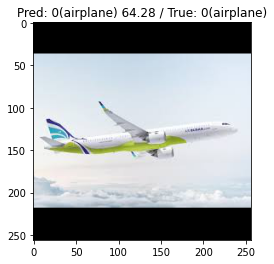

Predicted probability:
[0.59938496 0.400615  ]


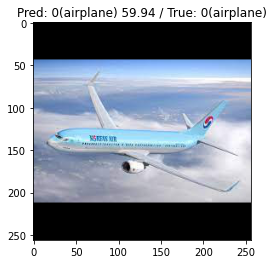

 False predicted images/total airplane category: 0 / 6
Category: helicopter
 True predicted images/total helicopter category: 2 / 3
Predicted probability:
[0.29441622 0.70558375]


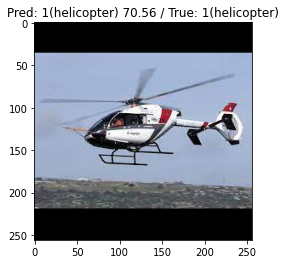

Predicted probability:
[0.21198785 0.78801215]


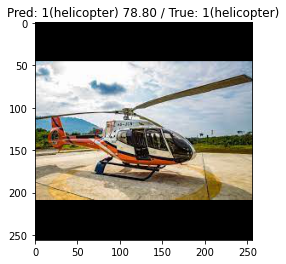

 False predicted images/total helicopter category: 1 / 3
Predicted probability:
[0.5117195  0.48828048]


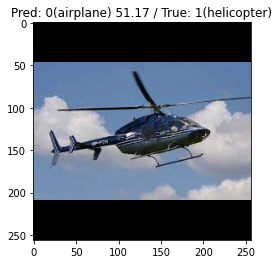

In [30]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)